# Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import re
import string
import warnings
from timeit import timeit
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# NLTK Imports and Downloads
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('yelp.csv')

## Data Prep

In [3]:
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",bkHUOCicGZ856vpvcWuW7Q,93z0yh-sUpGZS-cSKu6xxA,5.0,1,0,0,Stopped in on a busy Friday night. Despite the...,2018-03-04 00:59:21
1,1,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",VKBc48PPwyWIUE1RhBT_8A,Q_CZIvnsDHjpls-EPzzG7Q,2.0,0,0,0,Went there about 1 PM on a Monday. It wasn't ...,2018-08-14 05:22:00
2,2,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",JKNv1l7JgayZjG6nK__hXQ,rqxTSFFj5fZNmabY1fmTlw,5.0,0,0,0,This was the place the be on Friday Night! If ...,2018-03-17 14:22:48
3,3,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",WNM_Oyzy6mB6n0Z9lcuZyQ,vNPxlt5f50q0e2nVAScW3Q,4.0,0,0,0,Went to this place with my family over the wee...,2018-04-04 21:16:50
4,4,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",jG4gZz5FrHyItJXz1YV9Sw,eXRC79iX60xwA1UuGRuWNg,4.0,0,0,0,"Stopped on a midweek afternoon, and so glad th...",2018-04-28 19:17:04


In [4]:
df.shape

(100000, 23)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [5]:
# Drop NULL values
df.dropna(inplace=True)

In [6]:
# Drop unwanted columns
df.drop(columns=['Unnamed: 0', 'longitude', 'latitude'], inplace=True)

In [7]:
df['date'] =  pd.to_datetime(df['date'])

In [8]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['text']), axis = 1)

In [9]:
# add a column for positive or negative
df['target'] = df['stars_y'].apply(lambda c: 0 if c < 4 else 1)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [10]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 90652
After = 90652

Total Removed = 0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90652 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   business_id   90652 non-null  object        
 1   name          90652 non-null  object        
 2   address       90652 non-null  object        
 3   city          90652 non-null  object        
 4   state         90652 non-null  object        
 5   postal_code   90652 non-null  object        
 6   stars_x       90652 non-null  float64       
 7   review_count  90652 non-null  int64         
 8   is_open       90652 non-null  int64         
 9   attributes    90652 non-null  object        
 10  categories    90652 non-null  object        
 11  hours         90652 non-null  object        
 12  review_id     90652 non-null  object        
 13  user_id       90652 non-null  object        
 14  stars_y       90652 non-null  float64       
 15  useful        90652 non-null  int64 

In [12]:
print(len(df))
df = df[df['state'] != 'KS'].copy()
print(len(df))

90652
90649


## EDA

In [13]:
df.describe()

,stars_x,review_count,is_open,stars_y,useful,funny,cool,text_len,target
count,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000
mean,3.749611,424.967578,0.789319,3.802215,0.958190,0.326953,0.368454,576.716235,0.683802
std,0.639393,669.496044,0.407794,1.356062,2.103044,1.188864,1.193615,526.057956,0.464994
min,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,3.500000,79.000000,1.000000,3.000000,0.000000,0.000000,0.000000,236.000000,0.000000
50%,4.000000,214.000000,1.000000,4.000000,0.000000,0.000000,0.000000,416.000000,1.000000
75%,4.000000,477.000000,1.000000,5.000000,1.000000,0.000000,0.000000,733.000000,1.000000
max,5.000000,4708.000000,1.000000,5.000000,128.000000,39.000000,47.000000,5000.000000,1.000000


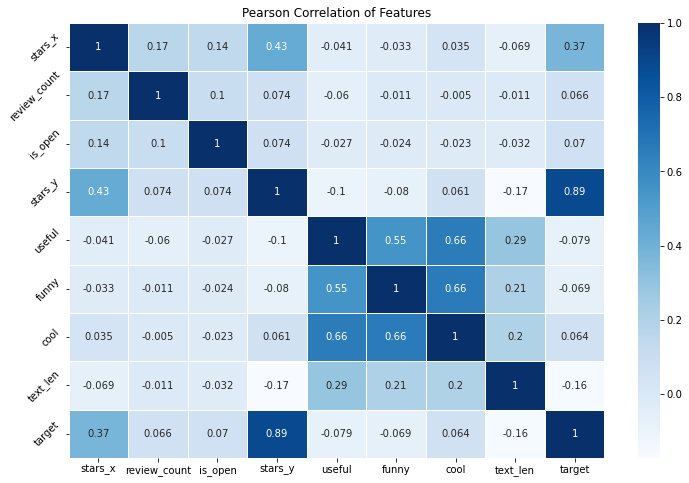

In [14]:
corr = df.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

**Observations:**  
There are a few variables that are correlated to each other.  
 - `target` was created from `stars_y` and therefore shows a high positive correlation
 - `cool`, `useful` and `funny` are slightly correlated to each other.  This probably means that users to vote with one item, vote with others. 
 - `stars_y` and `stars_x`also show some correlation.  This makes sense because `stars_x` is the mean of all `stars_y` ratings.

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work properly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of the text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to their *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `swimming` and `swimmer` will be reduced to `swim`.

**Note**: The original text will be preserved for other analysis.

In [15]:
df['text'][0]

"Stopped in on a busy Friday night. Despite the crowd, the service was expedient and warm. \n\nThe beers here speak for themselves, so we sampled some of their taproom only offerings, and the galaxy smash was clean, tropical and sessionable.\n\nThis being said, the real star of this place is the pizza. It's a hand tossed style crust, that's the perfect mix of crispy and doughy. We ordered the special pizza (luau- bacon, pineapple and fresh jalapeño), and it was the perfect mix of fat, sweetness and heat. \n\nIf you're looking for a comfortable spot to grab a beer, and share some food with some friends on pearl, this is the place!"

In [16]:
def clean_string(text, stem="None"):
    
    final_string = ""
    
    # Make lower
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    
    # Remove stop words
    text_filtered = [word for word in text if not word in useless_words]
    
    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [17]:
df['text_clean'] = df['text'].apply(lambda x: clean_string(x, stem='Stem'))

In [19]:
df['text_clean'][0]

'stop busi friday night despit crowd servic expedi warm beer speak sampl taproom offer galaxi smash clean tropic session said real star place pizza hand toss style crust that perfect mix crispi doughi order special pizza luau bacon pineappl fresh jalapeño perfect mix fat sweet heat your look comfort spot grab beer share food friend pearl place '

# FEATURE SELECTION/ MODELING 

>*In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons[11]:*

>- *simplification of models to make them easier to interpret by researchers/users,*
>- *shorter training times,*
>- *to avoid the curse of dimensionality,*
>- *enhanced generalization by reducing overfitting*

In [20]:
targets = ['categories', 'city', 'state', 'postal_code', 'is_open', 'text_len', 'useful', 'cool', 'funny', 'review_count']

In [21]:
catFeat = df[targets].copy()

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


catFeat['categories'] = le.fit_transform(catFeat['categories'].astype(str))
catFeat['city'] = le.fit_transform(catFeat['city'].astype(str))
catFeat['state'] = le.fit_transform(catFeat['state'].astype(str))
catFeat['postal_code'] = le.fit_transform(catFeat['postal_code'].astype(str))

catFeat.head()

,categories,city,state,postal_code,is_open,text_len,useful,cool,funny,review_count
0,2803,24,1,385,1,630,1,0,0,86
1,2803,24,1,385,1,885,0,0,0,86
2,2803,24,1,385,1,174,0,0,0,86
3,2803,24,1,385,1,553,0,0,0,86
4,2803,24,1,385,1,841,0,0,0,86


In [23]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(catFeat, 
                                                    df['target'], 
                                                    test_size=0.3, random_state=0)

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

clf.fit(X_train, y_train)

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, clf.feature_importances_):
    if feature[1] > .1:
        print(feature)
        total_importance += feature[1]
        
print('\nCumulative Importance of Selected Features: ', total_importance)

('categories', 0.16426808197116635)
('postal_code', 0.12921766618223368)
('text_len', 0.34660326772466077)
('review_count', 0.16382617229712215)

Cumulative Importance of Selected Features:  0.8039151881751829


## Model Selection

Many algorithms support binary classification.  We will use two and compare the results to select the best model.

 - **Random Forest Classifier**:  This classifier tends to be very robust.  It was used in the feature selection model above and will be tested against the features it selected.  Due to the nature of running many decision trees, it can take a while to compute larger datasets.
 > *A Random Forest classifier is an ensemble learning method for classification, regression, and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees [4].*
 - **Logistic Regression**: The logistic model is a fast and robust model that tends to run fairly quickly on all types of models.
 > *The logistic model (or logit model) is used to model the probability of a certain class or event existing, such as pass/fail, win/lose, alive/dead, or healthy/sick. This can be extended to model several classes of events, such as determining whether an image contains a cat, dog, or lion. Each object is detected in the image would be assigned a probability between 0 and 1, with a sum of one [5].*

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline.

**Imbalanced Data**  
The number of negative reviews is far less than the number of positive reviews. This is known as Imbalanced Data.  When you have imbalanced data, the model will tend to bias to the value with more observations (positive).  To correct this, we can run a process known as SMOTE.  This process uses a nearest-neighbor approach for generating new minority class samples.  The method is applied only to the training data and then tested on the original, untouched test partition.  The method chosen here is first to oversample the minority class making it balanced, and then undersample it to reduce the size.  This helps bring balance without bloating the dataset.

In [24]:
# To speed this up, let's just take a random subset of the data
# df = df.sample(n=15000)

In [25]:
X = df[['categories', 'postal_code', 'text_len', 'review_count', 'text_clean']]
y = df['target']

In [26]:
print(X.shape)
print(y.shape)

(90649, 5)
(90649,)


In [27]:
def create_pipe(clf, ngrams=(1,1)):
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
        [('Text', TfidfVectorizer(stop_words='english', ngram_range=ngrams), 'text_clean'),
         ('Categories', TfidfVectorizer(), 'categories'), 
         ('OHE', OneHotEncoder(dtype='int', handle_unknown='ignore'),['postal_code']),
         ('Numbers', MinMaxScaler(), ['review_count', 'text_len'])],
        remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [ ]:
models = {'RandForest' : RandomForestClassifier(random_state=42, n_estimators=50),
          'LogReg' : LogisticRegression(random_state=42, max_iter=1000)
          }

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

## Hyper Parameter Tuning

> *In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.*

<br>

> *Hyperparameters can be classified as model hyperparameters, that cannot be inferred while fitting the machine to the training set because they refer to the model selection task, or algorithm hyperparameters, that in principle have no influence on the performance of the model but affect the speed and quality of the learning process. An example of a model hyperparameter is the topology and size of a neural network. Examples of algorithm hyperparameters are learning rate and mini-batch size. [9]*

In [28]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [29]:
print(y_train.shape)
print(X_train.shape)

(60734,)
(60734, 5)


In [30]:
parameters = [{'clf__solver' : ['newton-cg', 'lbfgs', 'sag', 'liblinear'],
               'clf__C' : [.1, 1, 10, 100, 1000],
               'prep__Text__ngram_range': [(1, 1), (2, 2), (1, 2)]}]

In [31]:
clf = LogisticRegression(random_state=42, max_iter=500)
pipeline = create_pipe(clf)

In [32]:
pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('Text', TfidfVectorizer(stop_words='english'),
                                    'text_clean'),
                                   ('Categories', TfidfVectorizer(), 'categories'),
                                   ('OHE',
                                    OneHotEncoder(dtype='int',
                                                  handle_unknown='ignore'),
                                    ['postal_code']),
                                   ('Numbers', MinMaxScaler(),
                                    ['review_count', 'text_len'])])),
  ('over', SMOTE(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('clf', LogisticRegression(max_iter=500, random_state=42))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('Text', TfidfVectorizer(stop_words='english'),
                                  'text_clean'),
                                 ('Categories', TfidfVectorizer(), 'ca

In [ ]:
grid = GridSearchCV(pipeline, 
                    parameters, 
                    scoring='f1_macro', 
                    cv=3).fit(X_train, y_train)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

log_C = grid.best_params_['clf__C']
log_solver = grid.best_params_['clf__solver']
log_ngram = grid.best_params_['prep__Text__ngram_range']

In [33]:
log_C = 100
log_solver = 'newton-cg'
log_ngram = (1, 2)

58m 3s

```
Best cross-validation accuracy: 0.867
Test set score: 0.872
Best parameters: {'clf__C': 100, 'clf__solver': 'newton-cg', 'prep__Text__ngram_range': (1, 2)}
```

In [ ]:
grid = HalvingGridSearchCV(pipeline, 
                           parameters, 
                           scoring='f1_macro', 
                           cv=3).fit(X_train, y_train)


print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

log_C_b = grid.best_params_['clf__C']
log_solver_b = grid.best_params_['clf__solver']
log_ngram_b = grid.best_params_['prep__Text__ngram_range']

In [34]:
log_C_b = 100
log_solver_b = 'lbfgs'
log_ngram_b = (1, 2)

14m 28s

```
Best cross-validation accuracy: 0.867
Test set score: 0.872
Best parameters: {'clf__C': 100, 'clf__solver': 'lbfgs', 'prep__Text__ngram_range': (1, 2)}
```

# PERFORMANCE ASSESSMENT

Now that we have a model selected based on the cross-validation above, we can optimize the `Hyper Parameters` associated with the algorithm.  This allows for optimal results, potentially over and above the default settings.  

## Model Evaluation

In [36]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Purples)
    
    plt.tight_layout()
    plt.title(name)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(name + '.png', dpi=300) 
    plt.show; 

              precision    recall  f1-score   support

           0      0.789     0.845     0.816      9545
           1      0.925     0.894     0.909     20370

    accuracy                          0.879     29915
   macro avg      0.857     0.869     0.863     29915
weighted avg      0.882     0.879     0.880     29915



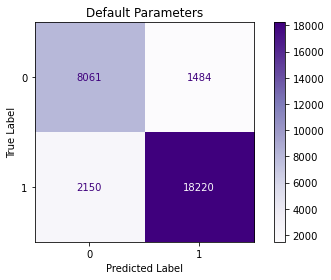

In [37]:
clf = LogisticRegression(random_state=42, max_iter=500)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'Default Parameters')

              precision    recall  f1-score   support

           0      0.839     0.810     0.824      9545
           1      0.913     0.927     0.920     20370

    accuracy                          0.890     29915
   macro avg      0.876     0.869     0.872     29915
weighted avg      0.889     0.890     0.889     29915



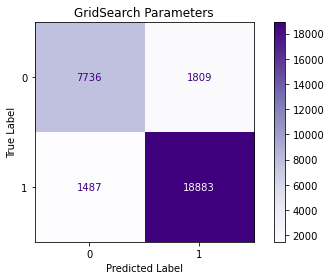

In [38]:
clf = LogisticRegression(C=log_C, solver=log_solver, random_state=42, max_iter=500)
pipeline = create_pipe(clf, log_ngram)
fit_and_print(pipeline, 'GridSearch Parameters')

              precision    recall  f1-score   support

           0      0.839     0.811     0.824      9545
           1      0.913     0.927     0.920     20370

    accuracy                          0.890     29915
   macro avg      0.876     0.869     0.872     29915
weighted avg      0.889     0.890     0.889     29915



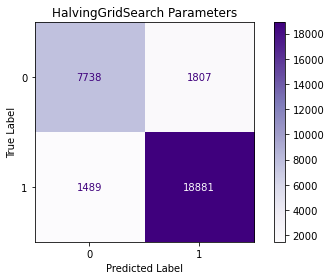

In [39]:
clf = LogisticRegression(C=log_C_b, solver=log_solver_b, random_state=42, max_iter=500)
pipeline = create_pipe(clf, log_ngram_b)
fit_and_print(pipeline, 'HalvingGridSearch Parameters')

https://towardsdatascience.com/hyperparameter-tuning-for-machine-learning-models-1b80d783b946